In [1]:
from functools import partial
import numpy as np
from matplotlib import pyplot as plt
import ants
import pandas as pd
from tqdm import tqdm
from affine_data_generators import *
import sys
sys.path.insert(0,'../pathology_unet/')
from metrics import *
import os
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm 
from torch.utils.data import DataLoader

/home/tanvi/.conda/envs/hbpenv/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
2022-08-03 20:13:16.999146: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
insti1 = 'feta_2.2'
insti2 = 'FeTA2022_Data_MedicalUniversityOfVienna_V1.0'
type1 = 'Neurotypical'
type2 = 'Pathological'
rectype1 = 'irtk'
rectype2 = 'nmic'

In [4]:
filenames_normal_1 = get_filenames(insti1,type1,rectype1)
filenames_normal_2 = get_filenames(insti2,type1,rectype2)

filenames_patho_1 = get_filenames(insti1,type2,rectype1)
filenames_patho_2 = get_filenames(insti2,type2,rectype2)

len(filenames_normal_1),len(filenames_normal_2),len(filenames_patho_1),len(filenames_patho_2)

(31, 33, 49, 7)

In [19]:
dl_normal_1 = CustomImageDataset(filenames_normal_1[-10:],reference,axis=0)
dl_normal_1 = DataLoader(dl_normal_1, batch_size=1, shuffle=False)

dl_normal_2 = CustomImageDataset(filenames_normal_2[-10:],reference,axis=1)
dl_normal_2 = DataLoader(dl_normal_2, batch_size=1, shuffle=False)

dl_patho_1 = CustomImageDataset(filenames_patho_1,reference,axis=0)
dl_patho_1 = DataLoader(dl_patho_1, batch_size=1, shuffle=False)

dl_patho_2 = CustomImageDataset(filenames_patho_2,reference,axis=1)
dl_patho_2 = DataLoader(dl_patho_2, batch_size=1, shuffle=False)

In [20]:
def evaluate_ants(data_generator):
    df = { 'vols': [],
                'Extra-axial CSF': [],
                'Gray Matter and developing cortical plate': [],
                'White matter and subplate': [],
                'Lateral ventricles': [],
                'Cerebellum': [],
                'Thalamus and putamen': [],
                'Brainstem': []
        }
    dl_iter = iter(data_generator)
    for i in tqdm(range(len(data_generator))):

        input_vols, filename =  next(dl_iter)
        np_seg_fxd = input_vols[3].detach().numpy().squeeze()
        np_seg_ants = input_vols[1].detach().numpy().squeeze()

        for label in range(1,8):
            dice = dice_score(np_seg_fxd,np_seg_ants,label)
            jc = jaccard(np_seg_fxd,np_seg_ants,label)
            hd = haussdorff_distance(np_seg_fxd, np_seg_ants, label,
                               percentile= 95, spacing_mm=[0.5, 0.5, 0.5])

            df[struct_list[label]].append([dice,jc,hd])
        df['vols'].append(filename[0].split('/')[2])
    return pd.DataFrame(df)

In [21]:
# df_normal_1 = evaluate_ants(dl_normal_1)
# df_normal_2 = evaluate_ants(dl_normal_2)
# df_patho_1 = evaluate_ants(dl_patho_1)
df_patho_2 = evaluate_ants(dl_patho_2)

  0%|                                                                                                                                    | 0/7 [00:00<?, ?it/s]/srv/tanvi/voxel_morph/../pathology_unet/metrics.py:499: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/srv/tanvi/voxel_morph/../pathology_unet/metrics.py:514: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

In [16]:
df_normal_1.to_csv('volume_metrics/ants_affine_normal_1.csv',index=False)
df_normal_2.to_csv('volume_metrics/ants_affine_normal_2.csv',index=False)
df_patho_1.to_csv('volume_metrics/ants_affine_patho_1.csv',index=False)
df_patho_2.to_csv('volume_metrics/ants_affine_patho_2.csv',index=False)

In [20]:
reference

'../feta_2.2/sub-026/anat/sub-026_rec-mial_T2w.nii.gz'

In [10]:
reference = '../feta_2.2/sub-026/anat/sub-026_rec-mial_T2w.nii.gz'
ants_ref = ants.image_read(reference)
ants_ref_seg = ants.image_read(reference.replace('T2w','dseg'))

In [11]:
ants_ref = ants_ref*(ants_ref_seg!=0)

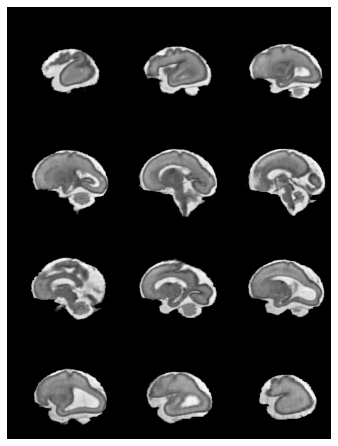

In [14]:
ants.plot(ants_ref)

In [25]:
ants_dir = 'syn_reg/'
def compute_ants_syn(vol_names):
    df_normal = { 'vols': [],
                'Extra-axial CSF': [],
                'Gray Matter and developing cortical plate': [],
                'White matter and subplate': [],
                'Lateral ventricles': [],
                'Cerebellum': [],
                'Thalamus and putamen': [],
                'Brainstem': []
        }
    for filename in tqdm(vol_names):
        try:
            ants_img = ants.image_read(filename)
        except:
            filename = filename.replace('irtk','mial')
            ants_img = ants.image_read(filename) 

        ants_seg = ants.image_read(filename.replace('T2w','dseg'))

        ants_img = ants_img*(ants_seg!=0)
        tfm_path = ants_dir + filename.split('/')[2] + '0GenericAffine.mat'
#         if not os.path.exists(tfm_path):
        ants_affinereg_tfm = ants.registration(fixed=ants_img,moving=ants_ref,
                                               aff_metric='GC',type_of_transform='SyN',
                                              outprefix= ants_dir + filename.split('/')[2])

        os.remove(ants_affinereg_tfm['fwdtransforms'][0])
        os.remove(ants_affinereg_tfm['invtransforms'][-1])

        ants_warped = ants.apply_transforms(fixed= ants_seg,
                                     moving= ants_ref_seg,
                                     transformlist= tfm_path,
                                     interpolator= 'nearestNeighbor'
                                    )
        np_seg_fxd = ants_seg.numpy()
        np_seg_ants = ants_warped.numpy()

        for label in range(1,8):
            dice = dice_score(np_seg_fxd,np_seg_ants,label)
            jc = jaccard(np_seg_fxd,np_seg_ants,label)
            hd = haussdorff_distance(np_seg_fxd, np_seg_ants, label,
                               percentile= 95, spacing_mm=[0.5, 0.5, 0.5])

            df_normal[struct_list[label]].append([dice,jc,hd])
        df_normal['vols'].append(filename.split('/')[2])
    return pd.DataFrame(df_normal)

In [26]:
df_normal_1 = compute_ants_syn(filenames_normal_1[-10:])
df_normal_2 = compute_ants_syn(filenames_normal_2[-10:])
df_patho_1 = compute_ants_syn(filenames_patho_1)
df_patho_2 = compute_ants_syn(filenames_patho_2)

  0%|                                                                                                                                   | 0/10 [00:00<?, ?it/s]/srv/tanvi/voxel_morph/../pathology_unet/metrics.py:499: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/srv/tanvi/voxel_morph/../pathology_unet/metrics.py:514: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

In [27]:
df_normal_1.to_csv('volume_metrics/ants_syn_normal_1.csv',index=False)
df_normal_2.to_csv('volume_metrics/ants_syn_normal_2.csv',index=False)
df_patho_1.to_csv('volume_metrics/ants_syn_patho_1.csv',index=False)
df_patho_2.to_csv('volume_metrics/ants_syn_patho_2.csv',index=False)

In [28]:
ants_dir = 'affine_reg/'

def compute_ants_affine(vol_names,institute):
    df_normal = { 'vols': [],
                'Extra-axial CSF': [],
                'Gray Matter and developing cortical plate': [],
                'White matter and subplate': [],
                'Lateral ventricles': [],
                'Cerebellum': [],
                'Thalamus and putamen': [],
                'Brainstem': []
        }
    for filename in tqdm(vol_names):
        try:
            ants_img = ants.image_read(filename)
        except:
            filename = filename.replace('irtk','mial')
            ants_img = ants.image_read(filename) 

        ants_seg = ants.image_read(filename.replace('T2w','dseg'))

        ants_img = ants_img*(ants_seg!=0)
        tfm_path = ants_dir + filename.split('/')[2] + '0GenericAffine.mat'
#         if not os.path.exists(tfm_path):
        ants_affinereg_tfm = ants.registration(fixed=ants_img,moving=ants_ref,
                                           aff_metric='GC',type_of_transform='Affine',
                                          outprefix= ants_dir + filename.split('/')[2])

        ants_warped = ants.apply_transforms(fixed= ants_seg,
                                     moving= ants_ref_seg,
                                     transformlist= tfm_path,
                                     interpolator= 'nearestNeighbor'
                                    )
        np_seg_fxd = ants_seg.numpy()
        np_seg_ants = ants_warped.numpy()
        
        if institute ==1:
            np_seg_fxd = np_seg_fxd[50:114,:,:]
            np_seg_ants = np_seg_ants[50:114,:,:]
        if institute == 2:
            np_seg_fxd = np_seg_fxd[:,96:160,:]
            np_seg_ants = np_seg_ants[:,96:160,:]
            
        for label in range(1,8):
            dice = dice_score(np_seg_fxd,np_seg_ants,label)
            jc = jaccard(np_seg_fxd,np_seg_ants,label)
            hd = haussdorff_distance(np_seg_fxd, np_seg_ants, label,
                               percentile= 95, spacing_mm=[0.5, 0.5, 0.5])

            df_normal[struct_list[label]].append([dice,jc,hd])
        df_normal['vols'].append(filename.split('/')[2])
    return pd.DataFrame(df_normal)

In [29]:
df_normal_1 = compute_ants_affine(filenames_normal_1[:-10],1)
df_normal_2 = compute_ants_affine(filenames_normal_2[:-10],2)
# df_patho_1 = compute_ants_affine(filenames_patho_1,1)
# df_patho_2 = compute_ants_affine(filenames_patho_2,2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [05:40<00:00, 14.80s/it]


In [30]:
df_normal_1.to_csv('volume_metrics/ants_affine_normal_1Training.csv',index=False)
df_normal_2.to_csv('volume_metrics/ants_affine_normal_2Training.csv',index=False)

In [15]:
input_vols, path = next(iter(dl_patho_2))

In [17]:
np_seg_fxd = input_vols[3].detach().numpy().squeeze(1)
np_seg_ants = input_vols[1].detach().numpy().squeeze(1)

In [25]:
interact(visualise_volumes, batch_id = (0,1),x=(0,64),  alpha=(0.0,1.0,0.05), 
         fixed = fixed((np_seg_fxd==1).astype(np.uint8)), moving=fixed((np_seg_ants==1).astype(np.uint8)));

interactive(children=(IntSlider(value=0, description='batch_id', max=1), IntSlider(value=32, description='x', …

In [23]:
dice_score(np_seg_fxd,np_seg_ants,5)

1.0

In [30]:
path = path[0]

In [32]:
ants_img = ants.image_read(path) 
ants_seg = ants.image_read(path.replace('T2w','dseg'))
ants_img = ants_img*(ants_seg!=0)
ants_affinereg_tfm = ants.registration(fixed=ants_img,moving=new_ants,
                                           aff_metric='GC',type_of_transform='Affine',
                                          outprefix= 'trial')

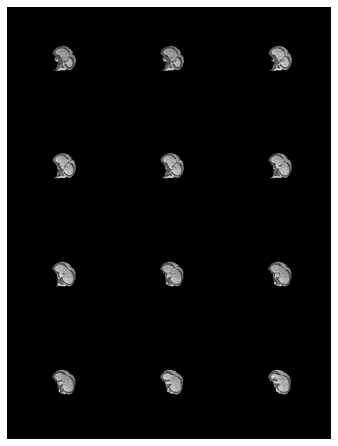

In [33]:
ants.plot(ants_img)

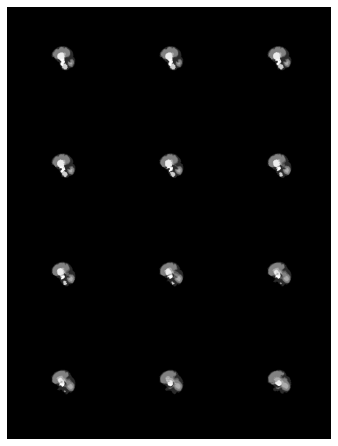

In [35]:
ants.plot(ants_warped)

In [34]:
tfm_path = 'trial0GenericAffine.mat'
ants_warped = ants.apply_transforms(fixed= ants_seg,
                             moving= ants_ref_seg,
                             transformlist= tfm_path,
                             interpolator= 'nearestNeighbor'
                            )

In [45]:
npseg = ants_seg.numpy()[:,96:160,:]
npaw = ants_warped.numpy()[:,96:160,:]
dice_score(npseg,npaw,5)

/srv/tanvi/voxel_morph/../pathology_unet/metrics.py:499: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/srv/tanvi/voxel_morph/../pathology_unet/metrics.py:514: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/srv/tanvi/voxel_morph/../pathology_unet/metrics.py:516: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence

0.07490396927016646

In [44]:
np.unique(npaw)

array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32)

In [55]:
dice_score(npseg,npaw,7)

0.1930988719309887

In [47]:
npseg[np.newaxis,...].shape

(1, 256, 64, 256)

In [48]:
interact(visualise_volumes, batch_id = (0,1),x=(0,64),  alpha=(0.0,1.0,0.05), 
         fixed = fixed((npseg[np.newaxis,...]).astype(np.uint8)), moving=fixed((npaw[np.newaxis,...]).astype(np.uint8)));

interactive(children=(IntSlider(value=0, description='batch_id', max=1), IntSlider(value=32, description='x', …